In [39]:
from googleapiclient.discovery import build
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy
import networkx as nx
from itertools import combinations
import math
import numpy as np
from collections import defaultdict
from statsmodels.distributions.empirical_distribution import ECDF
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns


In [2]:
# Canali target da cui raccogliere i video
channels = [
    "Fanpage.it",
    "La Repubblica",
    "FABRIZIO CORONA",
    "Gianluca Spina",
    "Gianmarco Zagato",
    "La7 Attualità",
    "Rai",
    "Bugalalla Crime",
    "DarkSide - Storia Segreta d'Italia"
]

# Intervallo temporale per i video (due settimana prima dalla riapertura del caso fino ai giorni odierni)
begin_date = datetime(2025, 2, 25)
end_date = datetime(2025, 6, 8)

In [3]:
# Crea struttura Comment
class Comment:
    def __init__(self, id, video_id, content, author, date, likes, reply_to_id=None):
        self.id = id
        self.video_id = video_id
        self.content = content
        self.author = author
        self.date = date
        self.likes = int(likes)
        self.reply_to_id = reply_to_id

    def __repr__(self):
        return f"<Comment by {self.author} on {self.date.strftime('%Y-%m-%d')}>"


In [17]:
# Carica file JSON unificati
with open("./comments.json", "r", encoding="utf-8") as f:
    comments = json.load(f)

with open("./videos.json", "r", encoding="utf-8") as f:
    videos = json.load(f)

with open("./videos_with_views.json", "r", encoding="utf-8") as f:
    videos_with_views = json.load(f)

In [21]:
# Strutture dati utilizzabili per l'analisi
# Mappa video_id → canale
Channel_of = {v["video_id"]: v["channel"] for v in videos}

# Mappa canale → lista video_id
Videos_of = defaultdict(list)
for v in videos:
    Videos_of[v["channel"]].append(v["video_id"])

# Mappa video_id → data
Date_of_video = {v["video_id"]: v["published_at"] for v in videos}

# Mappa video_id → views
Video_to_views = {v["video_id"]: v["viewCount"] for v in videos_with_views}

# Inizializza dizionari ausiliari
Commenters_of_video = defaultdict(set)
Videos_commented_by = defaultdict(set)
Channels_commented_by = defaultdict(set)
Commenters_of_channel = defaultdict(set)
Comments_of_channel = defaultdict(list)
Comments_by_user = defaultdict(list)

# Popola strutture dai commenti
for c in comments:
    video_id = c["video_id"]
    author = c["author"]
    channel = Channel_of.get(video_id, "Unknown")

    comment_obj = Comment(
        id=c["comment_id"],
        video_id=video_id,
        content=c["content"],
        author=author,
        date=c["date"],
        likes=c["likes"],
        reply_to_id=c.get("reply_to_id")
    )

    Commenters_of_video[video_id].add(author)
    Videos_commented_by[author].add(video_id)
    Channels_commented_by[author].add(channel)
    Commenters_of_channel[channel].add(author)
    Comments_of_channel[channel].append(comment_obj)
    Comments_by_user[author].append(comment_obj)

# Debug: stampa sommaria
print(f"Video totali: {len(Channel_of)}")
print(f"Utenti unici: {len(Comments_by_user)}")
print(f"Canali totali: {len(Videos_of)}")
print(f"Commenti totali: {len(comments)}")


Video totali: 239
Utenti unici: 24525
Canali totali: 8
Commenti totali: 110947


In [76]:
# Grafo utente-utente
G_utenti = nx.Graph()

edge_weights = defaultdict(int)

for video_id, commenters in Commenters_of_video.items():
    commenters = list(commenters)
    if len(commenters) < 2:
        continue
    for u1, u2 in combinations(commenters, 2):
        if u1 and u2:
            edge = tuple(sorted([u1, u2]))
            edge_weights[edge] += 1

for (u1, u2), weight in edge_weights.items():
    if weight >= 5:
        G_utenti.add_edge(u1, u2, weight=weight)

for user in G_utenti.nodes:
    num_videos = len(Videos_commented_by.get(user, set()))
    G_utenti.nodes[user]["video_count"] = num_videos

In [77]:
nx.write_gexf(G_utenti, "rete_utente_utente.gexf")

# Riepilogo
print("Utenti nella rete:", G_utenti.number_of_nodes())
print("Archi (connessioni ≥ 5 video):", G_utenti.number_of_edges())

Utenti nella rete: 3264
Archi (connessioni ≥ 5 video): 316750


In [ ]:
# Grafo Video–Video
all_videos = list(Channel_of.keys())

G_video = nx.Graph()

for v1, v2 in combinations(all_videos, 2):
    commenters1 = set(Commenters_of_video[v1])
    commenters2 = set(Commenters_of_video[v2])
    common_commenters = commenters1.intersection(commenters2)
    
    if len(common_commenters) > 0:
        G_video.add_edge(v1, v2, weight=len(common_commenters))

for video in G_video.nodes:
    G_video.nodes[video]["channel"] = Channel_of.get(video, "Unknown")
    G_video.nodes[video]["date"] = Date_of_video.get(video, "Unknown")

In [ ]:
nx.write_gexf(G_video, "rete_video_video.gexf")

# Riepilogo
print("Video nella rete:", G_video.number_of_nodes())
print("Archi creati:", G_video.number_of_edges())

Video nella rete: 239
Archi creati: 23825


In [34]:
video_video_G = nx.read_gexf("rete_video_video.gexf")

for n in video_video_G.nodes:
    video_video_G.nodes[n]['viewCount'] = Video_to_views.get(n, 0)
    print(f"Video {n} - Views: {video_video_G.nodes[n]['viewCount']}")

Video 0E2znss1aPI - Views: 53149
Video oaS-KJ0mz20 - Views: 32928
Video hMD5rLYDUrk - Views: 23917
Video 9jNySIytgp4 - Views: 29778
Video -tIRGBdPabA - Views: 83387
Video MkJULnHa9Ug - Views: 62653
Video rGQlVoynlWo - Views: 132453
Video jcym9wXec3c - Views: 24472
Video ibyXAAz-7eg - Views: 20723
Video s-HdzEdrcQQ - Views: 54934
Video PK-Q-YpAASU - Views: 37648
Video HoJIDggfkDU - Views: 38694
Video PXOOzIBVgKo - Views: 32927
Video 46FI8BwAQts - Views: 19383
Video QyZRLDgKGpM - Views: 24883
Video Uon0UXL9YtI - Views: 237920
Video 3KLuu0X2wu8 - Views: 207614
Video Vr-ijcH1WUc - Views: 34322
Video FBX4eUjjnuY - Views: 8039
Video gX3_L0Y0Qj4 - Views: 64296
Video 28zyiva4gBU - Views: 63254
Video hFc4N34GQh8 - Views: 39242
Video xlWQY1Jowss - Views: 64530
Video IYlpb1eNrk0 - Views: 8319
Video WBS2YDn7mBw - Views: 1055974
Video L71_s3pdMMk - Views: 263676
Video E_WfpcjwfMA - Views: 124034
Video 7Zlo_inISoc - Views: 2232094
Video PSZjFzIK3cM - Views: 141297
Video gPPYUOq7MNU - Views: 18796
Vi

In [71]:
# Calcolo della correlazione tra similarità Jaccard e differenza temporale
jaccard_similarities = []
time_differences = []

for node1, node2, data in G_video.edges(data=True):
    commenters1 = Commenters_of_video.get(node1, set())
    commenters2 = Commenters_of_video.get(node2, set())

    intersection = len(commenters1.intersection(commenters2))
    union = len(commenters1.union(commenters2))
    jaccard = intersection / union if union > 0 else 0

    date1 = datetime.fromisoformat(Date_of_video.get(node1, "2025-01-01"))
    date2 = datetime.fromisoformat(Date_of_video.get(node2, "2025-01-01"))
    diff_days = abs((date1 - date2).days)

    jaccard_similarities.append(jaccard)
    time_differences.append(diff_days)

# Correlazione Spearman
correlation, p_value = spearmanr(jaccard_similarities, time_differences)

print(f"\n=== Correlazione Jaccard vs Differenza Temporale ===")
print(f"ρ = {correlation:.4f}, p-value = {p_value:.6f}")
print(f"Media diff giorni: {np.mean(time_differences):.2f}, max: {np.max(time_differences)}")



=== Correlazione Jaccard vs Differenza Temporale ===
ρ = -0.1704, p-value = 0.000000
Media diff giorni: 30.89, max: 88


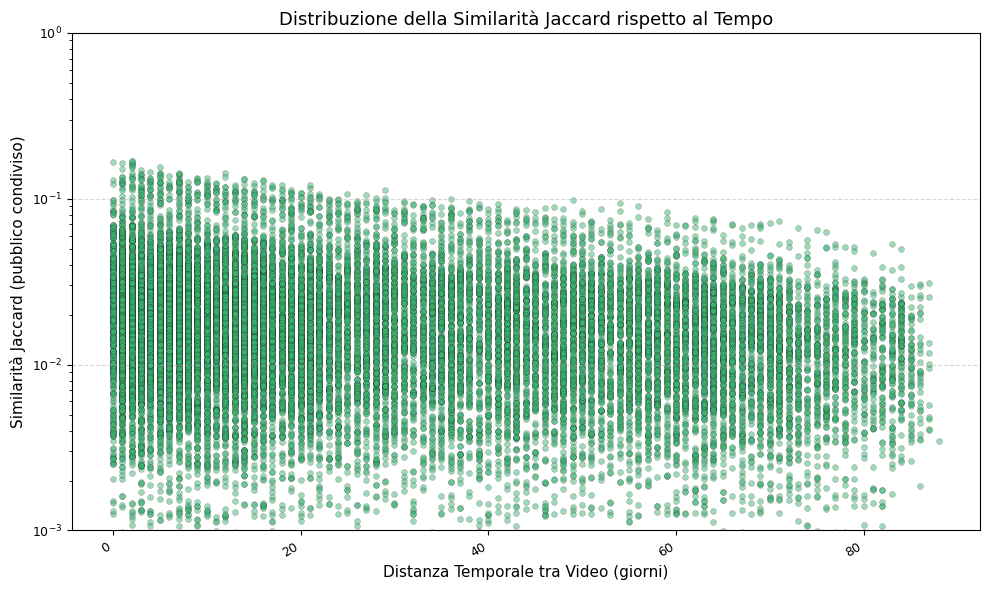

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(time_differences, jaccard_similarities, alpha=0.5, s=18, color='mediumseagreen', edgecolor='black', linewidth=0.2)
plt.xlabel("Distanza Temporale tra Video (giorni)", fontsize=11)
plt.ylabel("Similarità Jaccard (pubblico condiviso)", fontsize=11)
plt.title("Distribuzione della Similarità Jaccard rispetto al Tempo", fontsize=13)
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

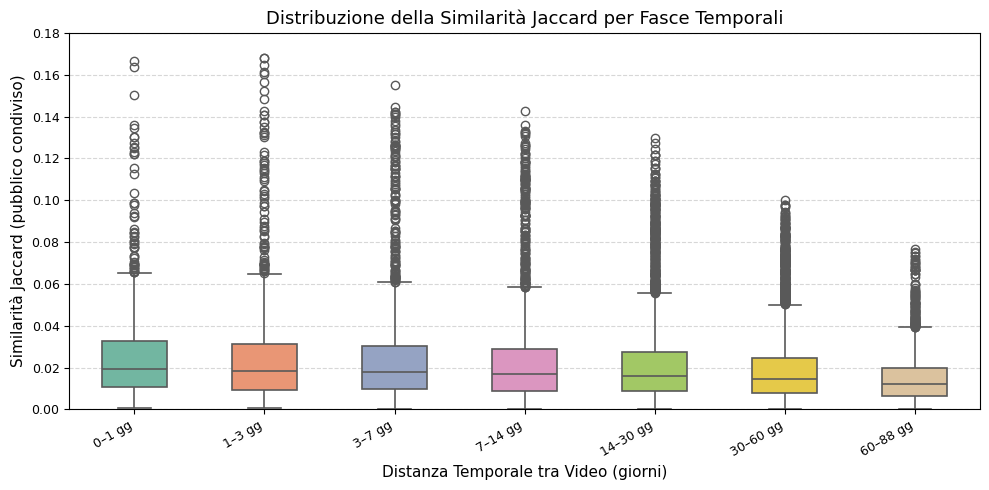


=== Statistiche per Bin Temporale ===
               mean    median       std       min       max  count
Tempo_Bin                                                         
0–1 gg     0.025150  0.019444  0.021539  0.000696  0.166667   1155
1–3 gg     0.025615  0.018288  0.025602  0.000685  0.167939   1189
3–7 gg     0.024173  0.017781  0.022546  0.000189  0.154913   2397
7–14 gg    0.022559  0.017049  0.020827  0.000378  0.142674   3463
14–30 gg   0.021644  0.016073  0.019338  0.000189  0.129889   5217
30–60 gg   0.018641  0.014388  0.015534  0.000378  0.100058   6583
60–88 gg   0.014364  0.012048  0.010712  0.000189  0.076598   3821


In [75]:
# Quanto influisce la distanza temporale tra due video sulla similarità del pubblico che li commenta?
df_inverse = pd.DataFrame({
    'Similarità Jaccard': jaccard_similarities,
    'Differenza Temporale (giorni)': time_differences
})

time_bins = [0, 1, 3, 7, 14, 30, 60, 88]
time_labels = [f"{time_bins[i]}–{time_bins[i+1]} gg" for i in range(len(time_bins)-1)]

df_inverse['Tempo_Bin'] = pd.cut(df_inverse['Differenza Temporale (giorni)'], bins=time_bins, labels=time_labels, include_lowest=True)
df_inverse.dropna(subset=['Tempo_Bin'], inplace=True)
df_inverse['Tempo_Bin'] = pd.Categorical(df_inverse['Tempo_Bin'], categories=time_labels, ordered=True)

plt.figure(figsize=(10, 5))  
sns.boxplot(
    x='Tempo_Bin',
    y='Similarità Jaccard',
    hue='Tempo_Bin',         
    data=df_inverse,
    palette='Set2',          
    showfliers=True,        
    width=0.5,               
    linewidth=1.2,
    legend=False             
)

plt.xlabel('Distanza Temporale tra Video (giorni)', fontsize=11)
plt.ylabel('Similarità Jaccard (pubblico condiviso)', fontsize=11)
plt.title('Distribuzione della Similarità Jaccard per Fasce Temporali', fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.ylim(0, 0.18)  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n=== Statistiche per Bin Temporale ===")
stats_by_time = df_inverse.groupby('Tempo_Bin', observed=True)['Similarità Jaccard'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(stats_by_time)
